# Model 5 - Simple fault

I want to create 3-4 simple models in order to show the effect of the distance algorithm for Kriging and how it can be applied to Gempy models. In general I think 3 Layers should be fine, cutting out the central one. Keeping all in the same size around max 5000 grid points gives reasonable calculation times.
1) flat horizontal 
2) anticline 
3) recumbent anticline
4) layer pinching out ?
5) should be something like a fault

In [17]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import pandas as pd

In [18]:
geo_data = gp.create_data([0,1000,0,20,0,1000],resolution=[100,2,100], 
                        path_o = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model5_orientations_slice.csv", path_i = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model5_interfaces_slice.csv")


In [19]:
gp.set_series(geo_data, {"Fault_Series":'fault', 
                         "Strat_Series": ('rock2','rock1')},
                       order_series = ["Fault_Series", 'Strat_Series'],
                       order_formations=['fault', 
                                         'rock2','rock1'
                                         ], verbose=0) 

In [34]:
colormodel = {'basement':'#ffa700','rock1':'#d62d20','rock2':'#0057e7','rock3':'#008744','fault':'#17202a'}
geo_data.set_colors(colormodel)
cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color'])[1:])
geo_data.formations

,value,formation_number,color
fault,1,1,#17202a
rock2,2,2,#0057e7
rock1,3,3,#d62d20
basement,4,4,#ffa700


In [21]:
#%matplotlib inline
#gp.get_sequential_pile(geo_data)

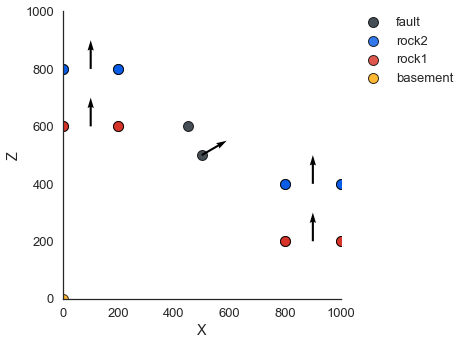

In [22]:
%matplotlib inline
gp.plotting.plot_data(geo_data, direction='y')

In [23]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  1


In [24]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


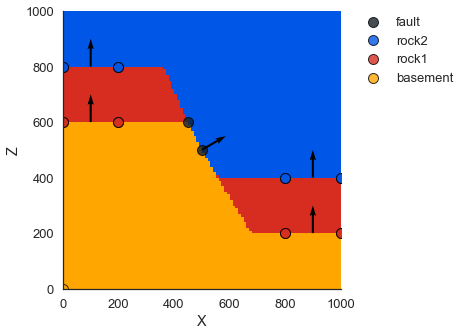

In [35]:
%matplotlib inline
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=True, cmap=cmap, norm=None)

plt.savefig(fname='Model5_pure_legend', edgecolor='black', bbox_inches="tight")

In [26]:
import gempy.utils.Kriging_Jan as krige

In [27]:
d = {'X': [600, 600], 'Y': [10, 10], 'Z': [500,500], 'Property': [20, 20]}
data_field = pd.DataFrame(data=d)
print(data_field)

     X   Y    Z  Property
0  600  10  500        20
1  600  10  500        20


In [28]:
test = krige.Kriging(data_field, lith_block, geo_data, formation_number=3, kriging_type='OK', distance_type='deformed')

initializing: 0.006995439529418945
distance precalculation: 24.380082368850708
submatrix extraction: 0.019986867904663086
distance Matrices: 0.35279393196105957
kriging calculation: 0.6346714496612549
Negative Variances: 0
Out of: 3151


In [29]:
coord3d_aux = test.grid_dataframe.values
coord3d_aux = np.delete(coord3d_aux, 3, 1)
coord3d_aux = np.swapaxes(coord3d_aux, 0,1) # for plotting later

contr_coord = test.control_coord
contr_coord = np.delete(contr_coord, (0), axis=0)
contr_coord = np.swapaxes(contr_coord, 0,1)

import matplotlib as mpl

# define the colormap
cmap = plt.cm.PuBu_r
# extract all colors
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,40,8)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

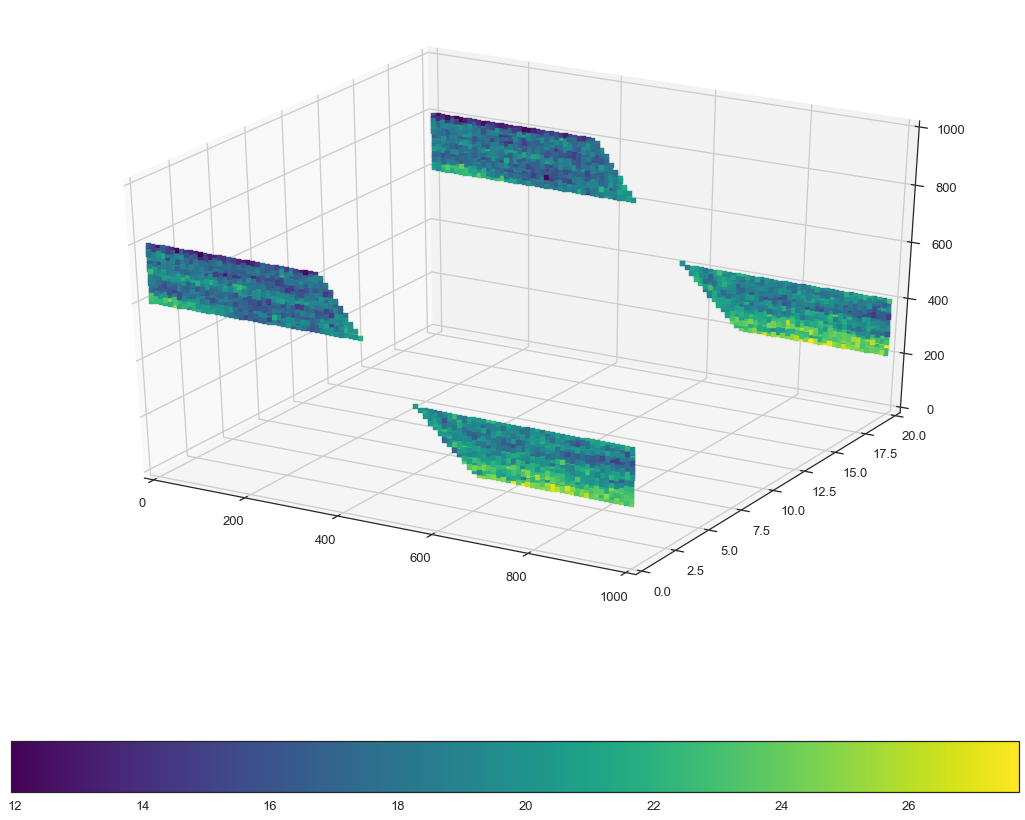

In [30]:
fig = plt.figure(figsize=(14, 12))
ax = Axes3D(fig)

ax.axes.set_zlim3d(0,1000)
ax.axes.set_xlim3d(0,1000)
ax.axes.set_ylim3d(0,20)
# a = ax.scatter3D(xs=test.result_coord[0],ys=test.result_coord[1],zs=test.result_coord[2], c=test.kriging_result[1], s=25, marker=',', cmap='viridis', norm=norm, alpha=1)
a = ax.scatter3D(xs=test.result_coord[0],ys=test.result_coord[1],zs=test.result_coord[2], c=test.kriging_result[1], s=25, marker=',', cmap='viridis', alpha=1)

fig.colorbar(a, orientation='horizontal')